In [1]:
%load_ext tensorboard

In [2]:
import tensorflow as tf
import numpy as np
import tensorboard
print(tf.config.list_physical_devices())


[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]


In [3]:
mapping = [
           'apple', 'arm', 'asparagus', 'axe', 'backpack', 'banana', 'bandage', 'barn', 'baseball bat', 'baseball',
           'bench', 'bicycle', 'binoculars', 'bird', 'birthday cake', 'blackberry', 'blueberry', 'book', 'boomerang', 'bottlecap',
           'bush', 'butterfly', 'cactus', 'cake', 'calculator', 'calendar', 'camel', 'camera', 'camouflage', 'campfire',
           'chair', 'chandelier', 'church', 'circle', 'clarinet', 'clock', 'cloud', 'coffee_cup', 'compass', 'computer',
           'diamond', 'dishwasher', 'diving_board', 'dog', 'dolphin', 'donut', 'door', 'dragon', 'dresser', 'drill',
           'harp', 'hat', 'headphones', 'hedgehog', 'helicopter', 'helmet', 'hexagon', 'hockey_puck', 'hockey_stick', 'horse',
           'hospital', 'hot_air_balloon', 'hot_dog', 'hot_tub', 'hourglass', 'house_plant', 'house', 'hurricane', 'ice_cream', 'jacket',
           'paper_clip', 'parachute', 'parrot', 'passport', 'peanut', 'pear', 'peas', 'pencil', 'penguin', 'piano',
           'popsicle', 'postcard', 'potato', 'power_outlet', 'purse', 'rabbit', 'raccoon', 'radio', 'rain', 'rainbow',
           'trombone', 'truck', 'trumpet', 'umbrella', 'underwear', 'van', 'vase', 'violin', 'washing_machine', 'watermelon',
]

In [4]:
NUM_OBJECTS = 100

In [5]:
class Generator(tf.keras.utils.Sequence):
    def __init__(self,filenames,labels,batch_size,train=False):
        self.image_filenames = filenames
        self.labels = labels
        self.batch_size = batch_size
        self.train = train
        
    def __len__(self) :
        return (np.ceil(len(self.image_filenames) / float(self.batch_size))).astype(int)
  
  
    def __getitem__(self, idx) :
        batch_x = self.image_filenames[idx * self.batch_size : (idx+1) * self.batch_size]
        batch_y = self.labels[idx * self.batch_size : (idx+1) * self.batch_size]

        images = []
        for fname in batch_x:
            with open(fname,"rb") as f:
                images.append(np.divide(np.load(f),255.0))#normalize pixel values
        return np.array(images), np.array(batch_y)

In [6]:
!pip install scikit-learn

In [7]:
from sklearn.model_selection import train_test_split

filenames = []
labels = []
for lab in range(NUM_OBJECTS):
    labels += [lab for _ in range(10_000)]
    for i in range(10_000):
        filenames.append(f"dataset/images/{lab}/{i}.npy")

labels = tf.keras.utils.to_categorical(labels)


train_X,test_X,train_y,test_y = train_test_split(filenames,labels,test_size=0.1)

train_X,val_X,train_y,val_y = train_test_split(train_X,train_y,test_size=0.22)

train_gen = Generator(train_X,train_y,50)
val_gen = Generator(val_X,val_y,10)

In [8]:
def get_model(input_shape,num_outputs):
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.Conv2D(16,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        tf.keras.layers.Conv2D(16,(3,3),activation="relu"),
        tf.keras.layers.MaxPooling2D(pool_size=(2,2),padding='same'),
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(1024,activation="relu"),
        tf.keras.layers.Dropout(0.4),
        tf.keras.layers.Dense(256,activation="relu"),
        tf.keras.layers.Dense(num_outputs,activation="softmax") #probability distribution output
    ])
    
    model.compile(
        optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
        loss=tf.keras.losses.CategoricalCrossentropy(from_logits=False),
        metrics="accuracy"
    )
    model.build()
    return model

In [9]:
model = get_model((64,64,1),NUM_OBJECTS)

In [10]:
from datetime import datetime
logdir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [11]:
model.fit(train_gen,
          epochs=10,
          validation_data=val_gen,
          callbacks=[
              tf.keras.callbacks.ReduceLROnPlateau(
                  monitor='val_accuracy', 
                  patience=3,
                  min_delta=0.0001,
                  factor=0.25,
                  min_lr=0.000001
                ),
              tf.keras.callbacks.EarlyStopping(
                  monitor='val_accuracy', 
                  patience=6, 
                  verbose=2,
                  mode='max',
                  restore_best_weights=True
                ),
              tf.keras.callbacks.ModelCheckpoint(
                     filepath='C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_best.h5', 
                     save_freq='epoch', verbose=1, monitor='val_accuracy', mode="max",
                     save_weights_only=True, save_best_only=True
                ),
              tensorboard_callback
          ])

Epoch 1/10


14039/14040 [============================>.] - ETA: 0s - loss: 2.0904 - accuracy: 0.4802
Epoch 1: val_accuracy improved from -inf to 0.63956, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-detection\models\model_best.h5
14040/14040 [==============================] - 853s 61ms/step - loss: 2.0903 - accuracy: 0.4802 - val_loss: 1.3999 - val_accuracy: 0.6396 - lr: 1.0000e-04
Epoch 2/10
14040/14040 [==============================] - ETA: 0s - loss: 1.4502 - accuracy: 0.6242
Epoch 2: val_accuracy improved from 0.63956 to 0.68803, saving model to C:\Users\Jake\Desktop\ai-playground\doodle-detection\models\model_best.h5
14040/14040 [==============================] - 728s 52ms/step - loss: 1.4502 - accuracy: 0.6242 - val_loss: 1.1976 - val_accuracy: 0.6880 - lr: 1.0000e-04
Epoch 3/10
14040/14040 [==============================] - ETA: 0s - loss: 1.2928 - accuracy: 0.6626
Epoch 3: val_accuracy improved from 0.68803 to 0.70996, saving model to C:\Users\Jake\Desktop\ai-pl

In [16]:
model.load_weights('C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_best.h5')

In [17]:
model.evaluate(Generator(test_X,test_y,10))

 3805/10000 [==========>...................] - ETA: 26s - loss: 0.9590 - accuracy: 0.7503

KeyboardInterrupt: 

In [15]:
model.save('C:\\Users\\Jake\\Desktop\\ai-playground\\doodle-detection\\models\\model_100obj.h5')

c:\Users\Jake\anaconda3\envs\ai-project\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


(64, 64, 1)


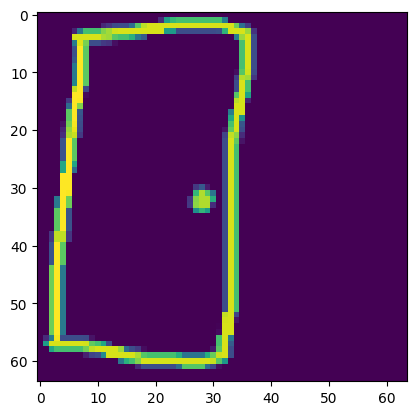

1/1 [==============================] - 1s 886ms/step
TRUE: door,PREDICT: door, 99.9%
(64, 64, 1)


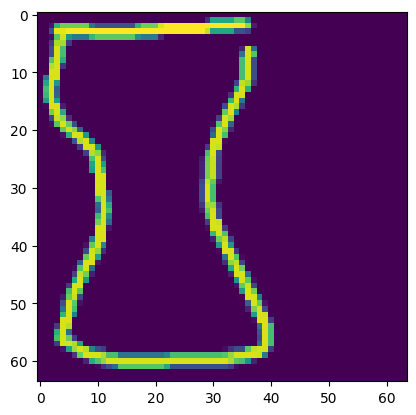

1/1 [==============================] - 0s 45ms/step
TRUE: hourglass,PREDICT: hourglass, 95.95%
(64, 64, 1)


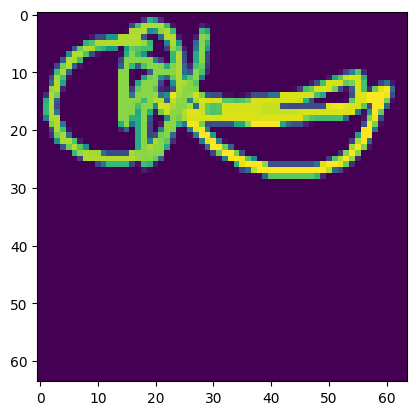

1/1 [==============================] - 0s 48ms/step
TRUE: hot_dog,PREDICT: trumpet, 32.85%
(64, 64, 1)


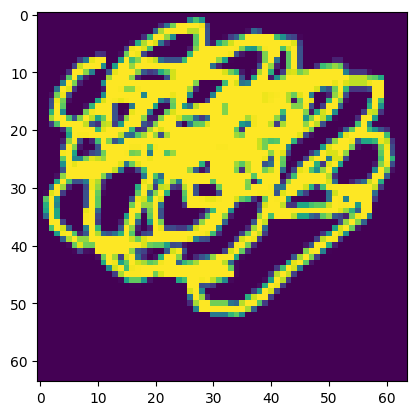

1/1 [==============================] - 0s 56ms/step
TRUE: blackberry,PREDICT: blackberry, 56.23%
(64, 64, 1)


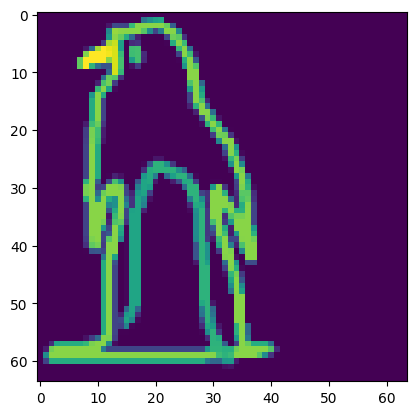

1/1 [==============================] - 0s 45ms/step
TRUE: penguin,PREDICT: penguin, 98.51%
(64, 64, 1)


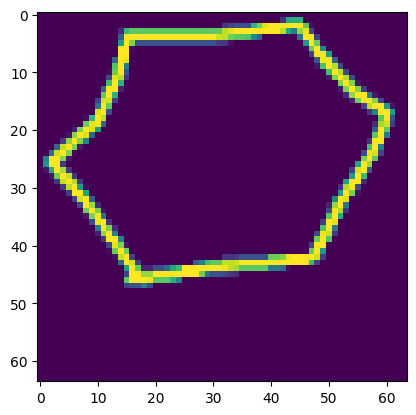

1/1 [==============================] - 0s 50ms/step
TRUE: hexagon,PREDICT: hexagon, 99.99%
(64, 64, 1)


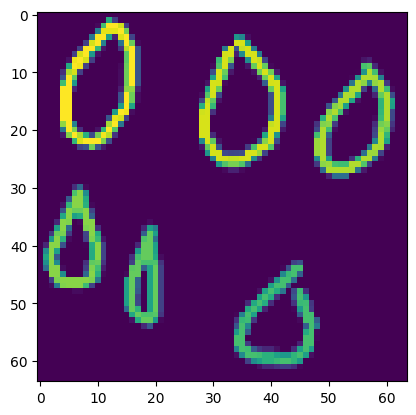

1/1 [==============================] - 0s 45ms/step
TRUE: rain,PREDICT: rain, 66.63%
(64, 64, 1)


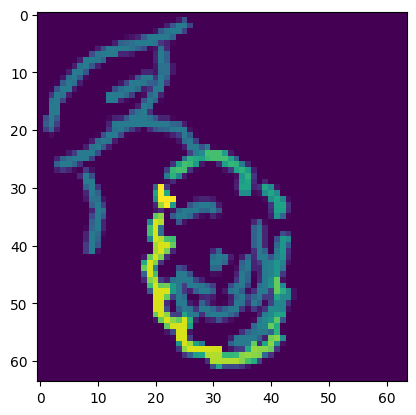

1/1 [==============================] - 0s 36ms/step
TRUE: blackberry,PREDICT: peas, 15.56%
(64, 64, 1)


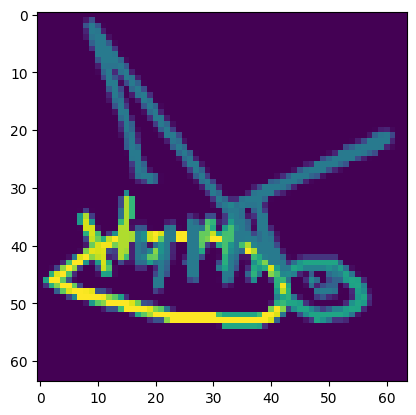

1/1 [==============================] - 0s 51ms/step
TRUE: hedgehog,PREDICT: campfire, 49.52%
(64, 64, 1)


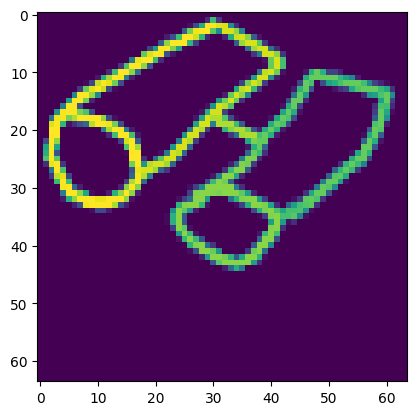

1/1 [==============================] - 0s 49ms/step
TRUE: binoculars,PREDICT: binoculars, 99.98%
(64, 64, 1)


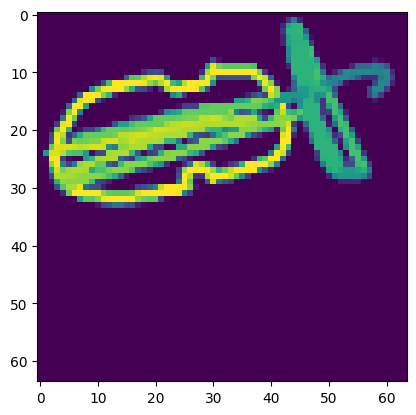

1/1 [==============================] - 0s 35ms/step
TRUE: violin,PREDICT: violin, 46.24%
(64, 64, 1)


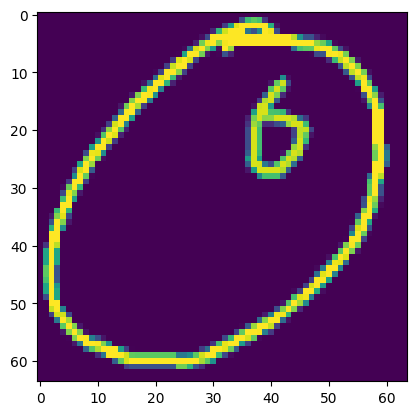

1/1 [==============================] - 0s 34ms/step
TRUE: blueberry,PREDICT: blueberry, 51.72%
(64, 64, 1)


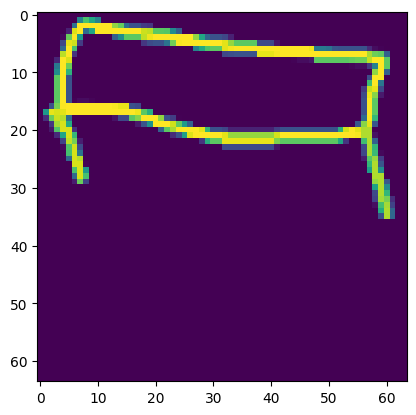

1/1 [==============================] - 0s 33ms/step
TRUE: bench,PREDICT: bench, 92.08%
(64, 64, 1)


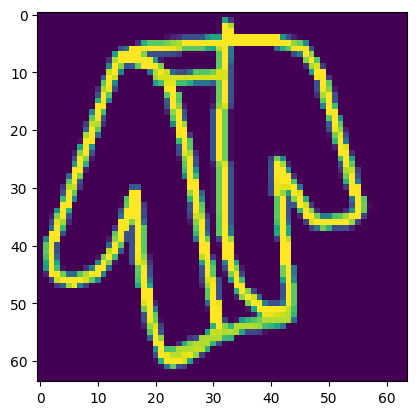

1/1 [==============================] - 0s 33ms/step
TRUE: jacket,PREDICT: jacket, 99.98%
(64, 64, 1)


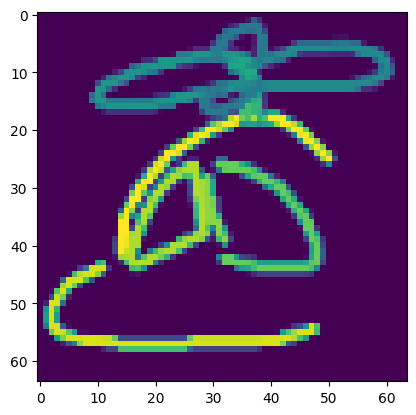

1/1 [==============================] - 0s 35ms/step
TRUE: helicopter,PREDICT: helicopter, 87.78%
(64, 64, 1)


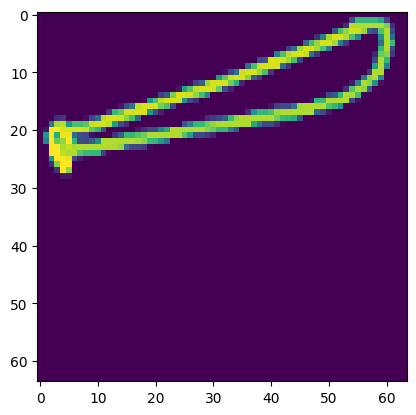

1/1 [==============================] - 0s 40ms/step
TRUE: baseball bat,PREDICT: baseball bat, 78.75%
(64, 64, 1)


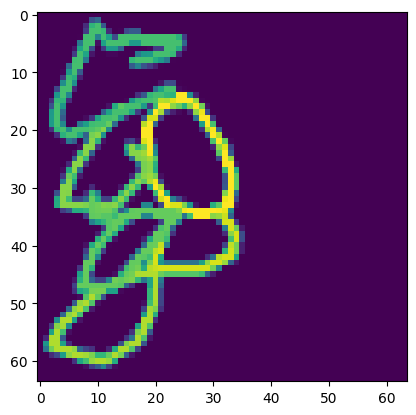

1/1 [==============================] - 0s 50ms/step
TRUE: blueberry,PREDICT: parrot, 14.09%
(64, 64, 1)


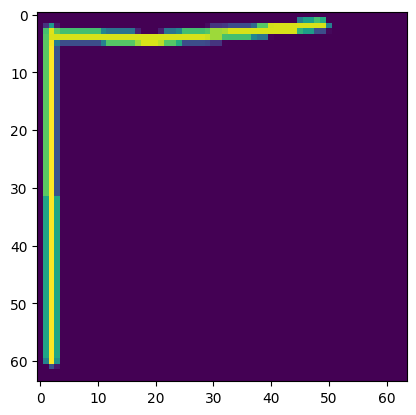

1/1 [==============================] - 0s 34ms/step
TRUE: diving_board,PREDICT: diving_board, 94.5%
(64, 64, 1)


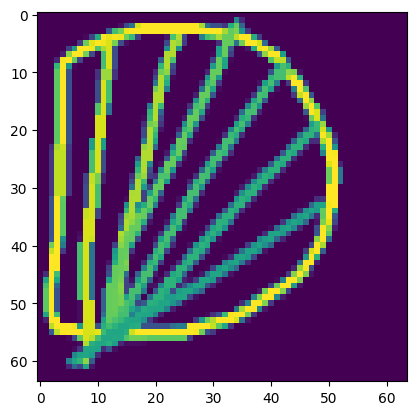

1/1 [==============================] - 0s 53ms/step
TRUE: harp,PREDICT: harp, 99.09%
(64, 64, 1)


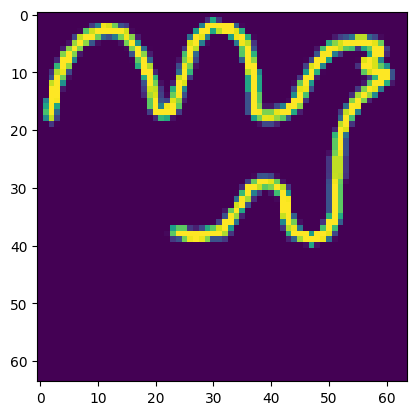

1/1 [==============================] - 0s 38ms/step
TRUE: camel,PREDICT: camel, 99.86%
(64, 64, 1)


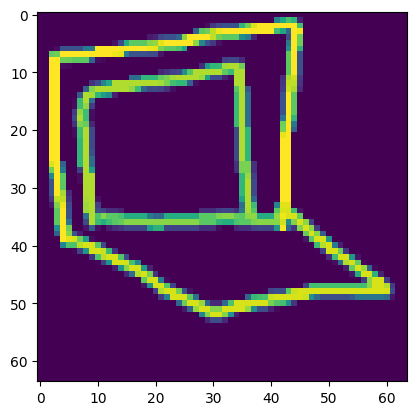

1/1 [==============================] - 0s 43ms/step
TRUE: dishwasher,PREDICT: computer, 95.91%
(64, 64, 1)


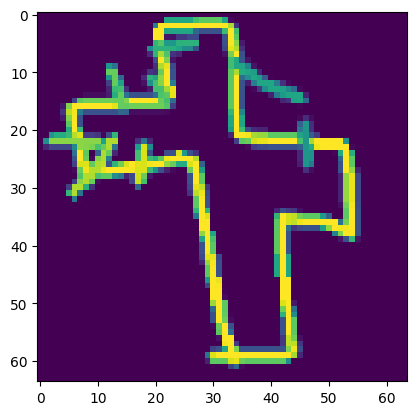

1/1 [==============================] - 0s 36ms/step
TRUE: cactus,PREDICT: hospital, 52.57%
(64, 64, 1)


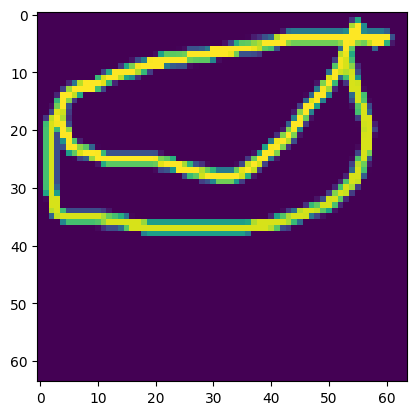

1/1 [==============================] - 0s 36ms/step
TRUE: hockey_puck,PREDICT: hockey_puck, 85.4%
(64, 64, 1)


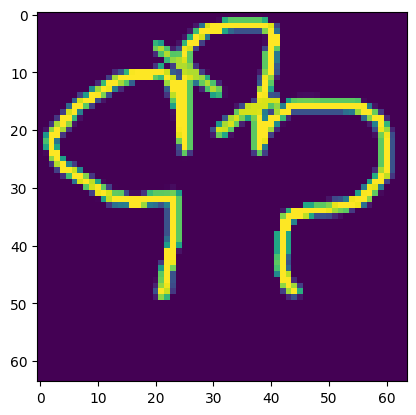

1/1 [==============================] - 0s 51ms/step
TRUE: cactus,PREDICT: butterfly, 79.85%
(64, 64, 1)


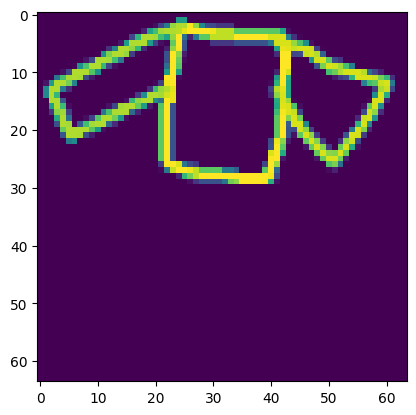

1/1 [==============================] - 0s 36ms/step
TRUE: jacket,PREDICT: jacket, 96.41%
(64, 64, 1)


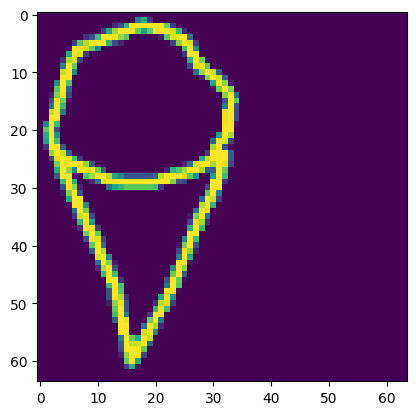

1/1 [==============================] - 0s 39ms/step
TRUE: ice_cream,PREDICT: ice_cream, 99.97%
(64, 64, 1)


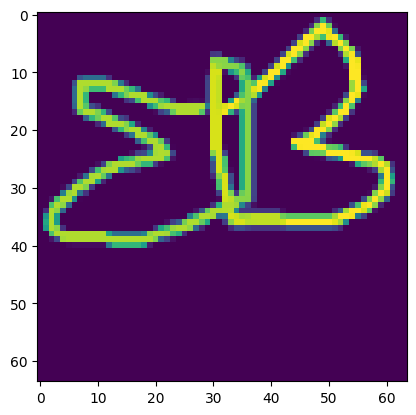

1/1 [==============================] - 0s 36ms/step
TRUE: butterfly,PREDICT: butterfly, 99.86%
(64, 64, 1)


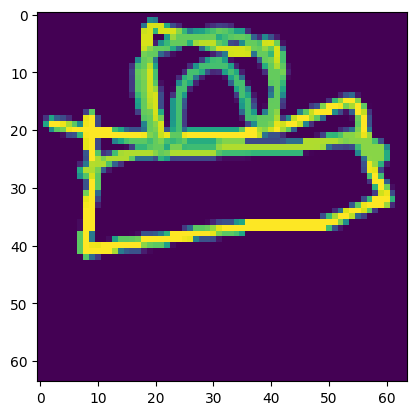

1/1 [==============================] - 0s 34ms/step
TRUE: purse,PREDICT: cake, 53.65%
(64, 64, 1)


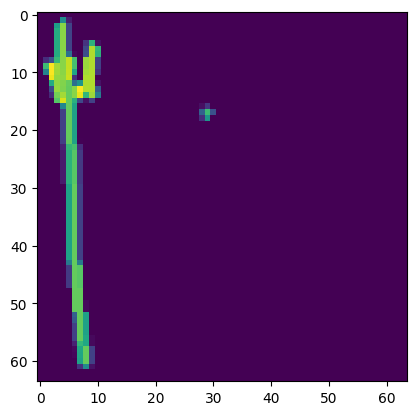

1/1 [==============================] - 0s 34ms/step
TRUE: asparagus,PREDICT: asparagus, 74.89%
(64, 64, 1)


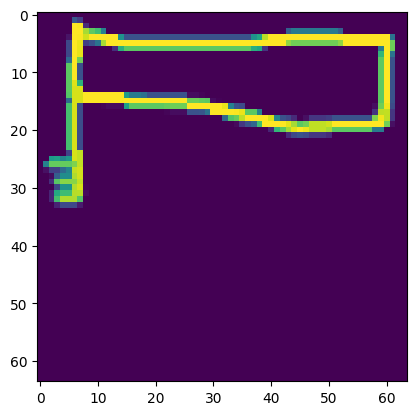

1/1 [==============================] - 0s 33ms/step
TRUE: diving_board,PREDICT: bench, 74.1%
(64, 64, 1)


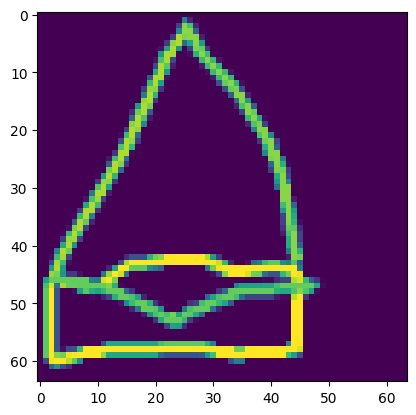

1/1 [==============================] - 0s 46ms/step
TRUE: purse,PREDICT: purse, 59.98%
(64, 64, 1)


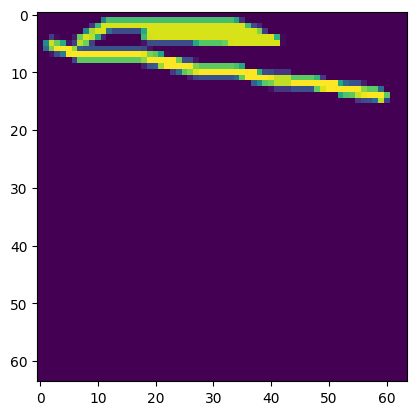

1/1 [==============================] - 0s 37ms/step
TRUE: pencil,PREDICT: diving_board, 74.42%
(64, 64, 1)


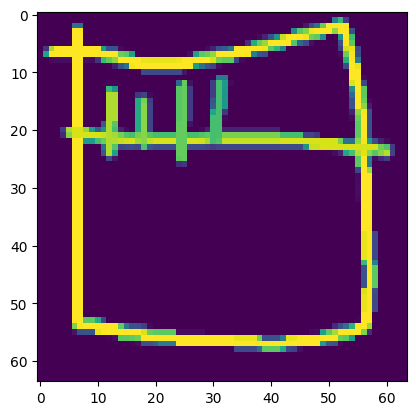

1/1 [==============================] - 0s 37ms/step
TRUE: dishwasher,PREDICT: dishwasher, 38.47%
(64, 64, 1)


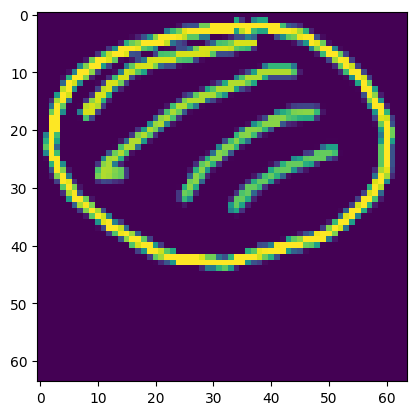

1/1 [==============================] - 0s 32ms/step
TRUE: watermelon,PREDICT: watermelon, 94.06%
(64, 64, 1)


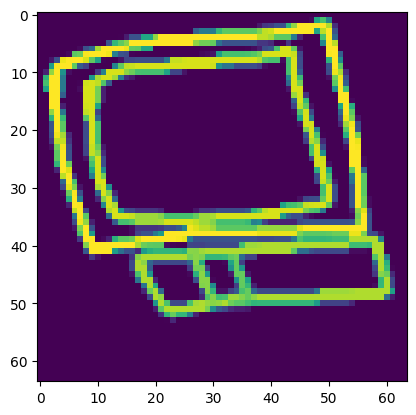

1/1 [==============================] - 0s 32ms/step
TRUE: computer,PREDICT: computer, 97.48%
(64, 64, 1)


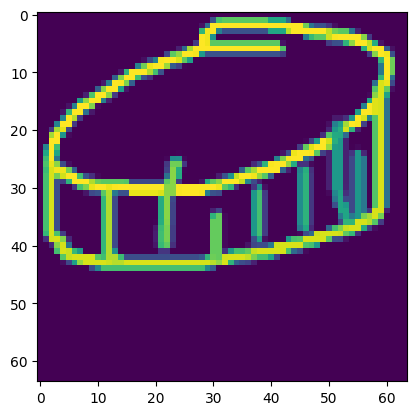

1/1 [==============================] - 0s 33ms/step
TRUE: bottlecap,PREDICT: bottlecap, 79.97%
(64, 64, 1)


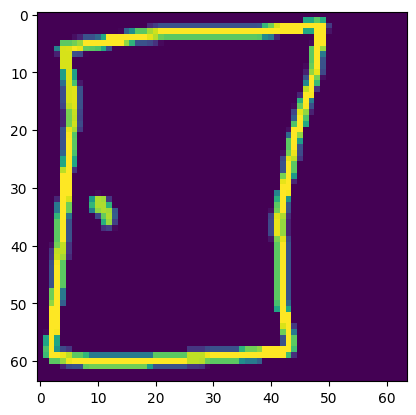

1/1 [==============================] - 0s 33ms/step
TRUE: door,PREDICT: door, 98.91%
(64, 64, 1)


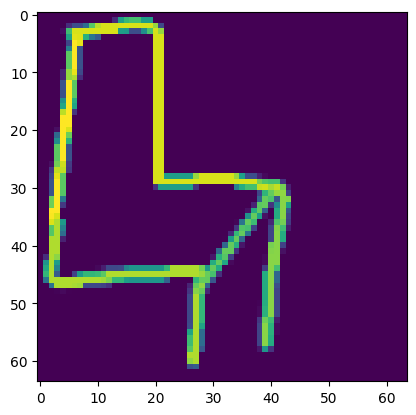

1/1 [==============================] - 0s 34ms/step
TRUE: chair,PREDICT: chair, 99.74%
(64, 64, 1)


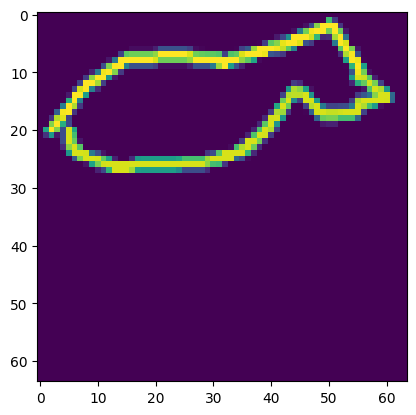

1/1 [==============================] - 0s 36ms/step
TRUE: bird,PREDICT: bird, 25.18%
(64, 64, 1)


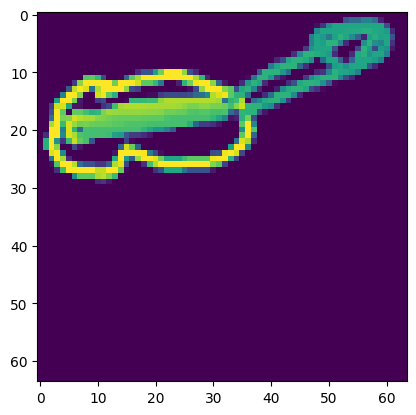

1/1 [==============================] - 0s 34ms/step
TRUE: violin,PREDICT: violin, 48.25%
(64, 64, 1)


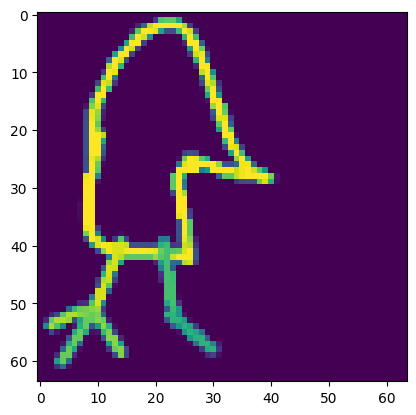

1/1 [==============================] - 0s 39ms/step
TRUE: parrot,PREDICT: parrot, 62.1%
(64, 64, 1)


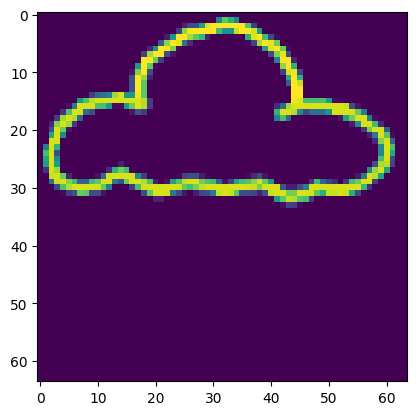

1/1 [==============================] - 0s 35ms/step
TRUE: cloud,PREDICT: cloud, 89.89%
(64, 64, 1)


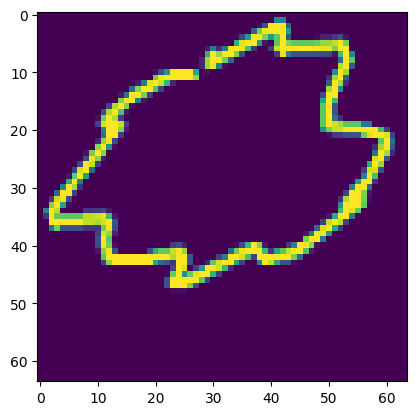

1/1 [==============================] - 0s 38ms/step
TRUE: cloud,PREDICT: cloud, 53.02%
(64, 64, 1)


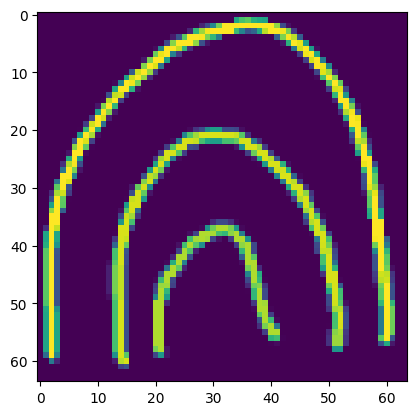

1/1 [==============================] - 0s 36ms/step
TRUE: rainbow,PREDICT: rainbow, 96.75%
(64, 64, 1)


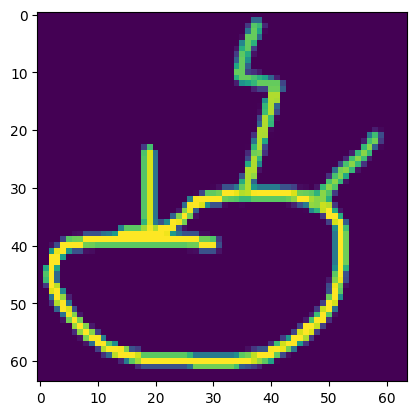

1/1 [==============================] - 0s 36ms/step
TRUE: birthday cake,PREDICT: hedgehog, 33.15%
(64, 64, 1)


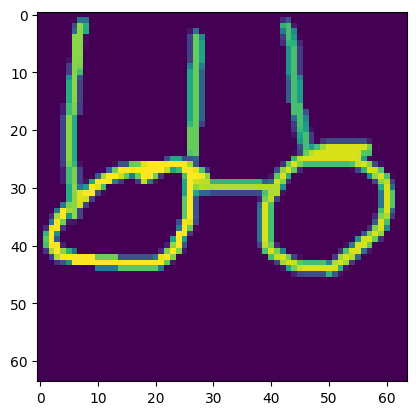

1/1 [==============================] - 0s 34ms/step
TRUE: binoculars,PREDICT: binoculars, 99.66%
(64, 64, 1)


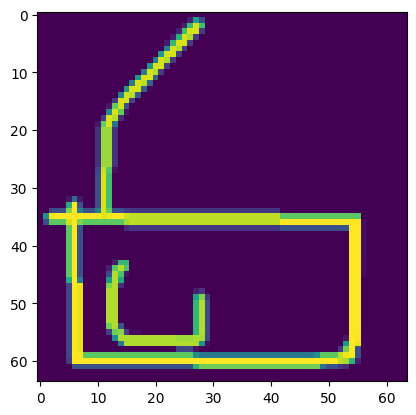

1/1 [==============================] - 0s 36ms/step
TRUE: radio,PREDICT: radio, 56.53%
(64, 64, 1)


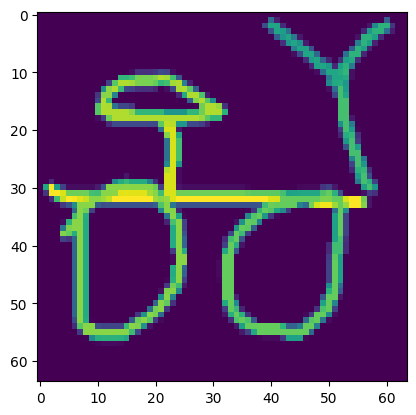

1/1 [==============================] - 0s 32ms/step
TRUE: bicycle,PREDICT: bicycle, 83.95%
(64, 64, 1)


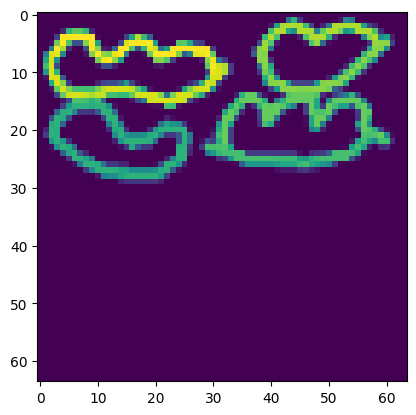

1/1 [==============================] - 0s 34ms/step
TRUE: cloud,PREDICT: raccoon, 18.64%
(64, 64, 1)


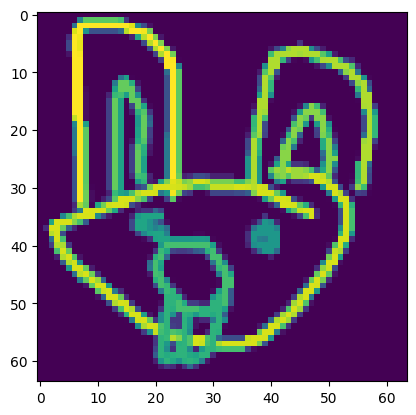

1/1 [==============================] - 0s 37ms/step
TRUE: rabbit,PREDICT: rabbit, 95.91%


In [18]:
from matplotlib import pyplot as plt


for i in range(50):
    fname = test_X[i]
    img = None
    with open(fname,"rb") as f:
        img = np.divide(np.load(f),255.0)
    print(img.shape)
    plt.imshow(img, interpolation='nearest')
    plt.show()
    
    label = np.argmax(test_y[i])
    pred = model.predict(Generator([fname],[label],1))[0]
    pred_label = np.argmax(pred)
    perc = pred[pred_label]
    print(f'TRUE: {mapping[label]},PREDICT: {mapping[pred_label]}, {round(perc*100,2)}%')
    
